In [1]:
import torch, torchvision
from torchvision import transforms
from torch import nn
import numpy as np
import sys
import os
from glob import glob
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
eeg_emo0 = np.load('Data/eeg_emo_chan.npy')
targets = np.load('Data/targets.npy')
print(eeg_emo0.shape)
print(targets.shape)

(1280, 16, 8064)
(1280, 4)


In [3]:
eeg_emo0 = eeg_emo0[:400]
targets  = targets[:400]

In [4]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
frontal_lobes = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'P3', 'P4']

In [5]:
import mne
from mne import create_info
from mne.io import RawArray

In [6]:
def df_to_raw(df):
    sfreq = 128
    ch_names = frontal_lobes
    ch_types = 16*['eeg']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    #df = df.T  #mne looks at the tranpose()  ## my data already trans
    #df[:-1] *= 1e-6  #convert from uVolts to Volts (mne assumes Volts data)

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)

    #try plotting the raw data of its power spectral density
    #raw.plot_psd()

    return raw

In [7]:
raws = []
for i in range(eeg_emo0.shape[0]):
    raws.append(df_to_raw(eeg_emo0[i]))

Creating RawArray with float64 data, n_channels=16, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.

Effective window size : 16.000 (s)


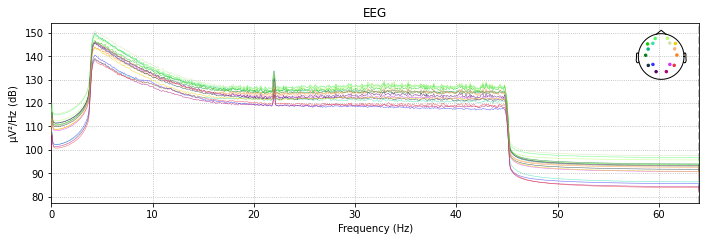

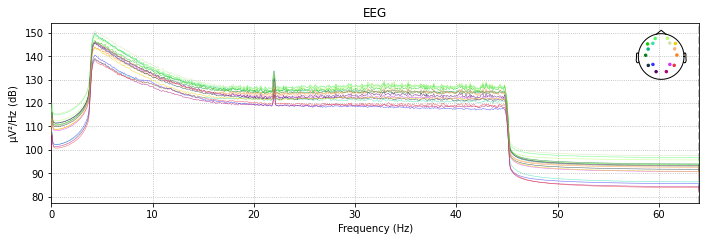

In [8]:
raw = mne.io.concatenate_raws(raws)
raw.plot_psd()

In [9]:
from mne.preprocessing import ICA
filt_raw = raw.copy()
ica = ICA(n_components=16, random_state=32)
ica.fit(filt_raw)

Fitting ICA to data using 16 channels (please be patient, this may take a while)


<ipython-input-9-a3e2030e4364>:4: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(filt_raw)


Selecting by number: 16 components
Fitting ICA took 60.9s.


Method,fastica
Fit,21 iterations on raw data (3225600 samples)
ICA components,16
Explained variance,100.0 %
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=16, n_times=3225600
    Range : 0 ... 3225599 =      0.000 ... 25199.992 secs
Ready.
Using matplotlib as 2D backend.


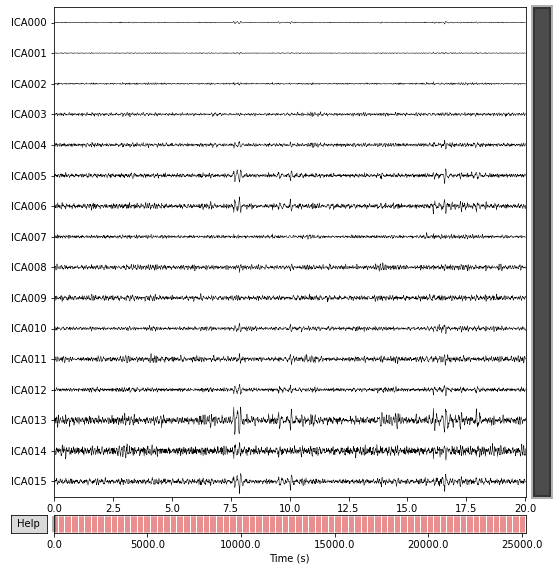

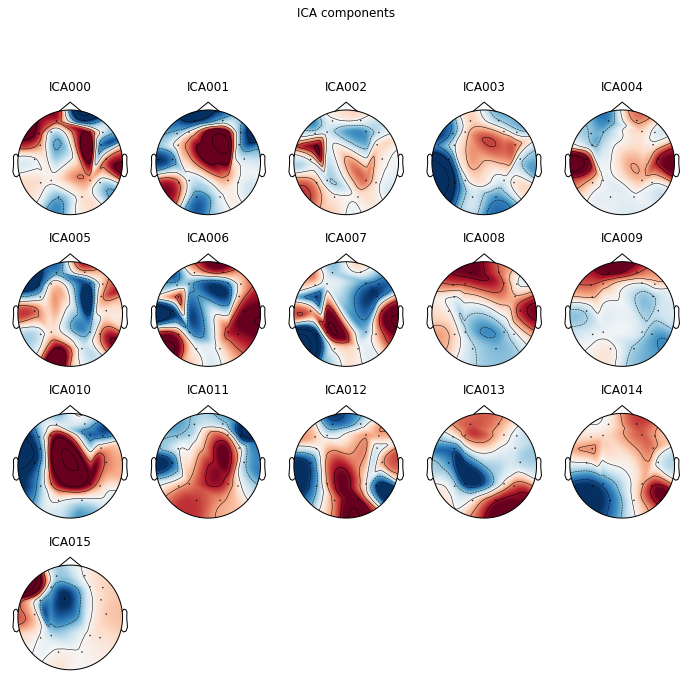

[<MNEFigure size 702x696.24 with 16 Axes>]

In [10]:
ica.plot_sources(filt_raw)
ica.plot_components()

Effective window size : 16.000 (s)


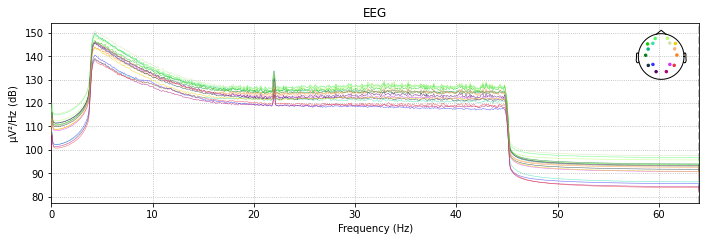

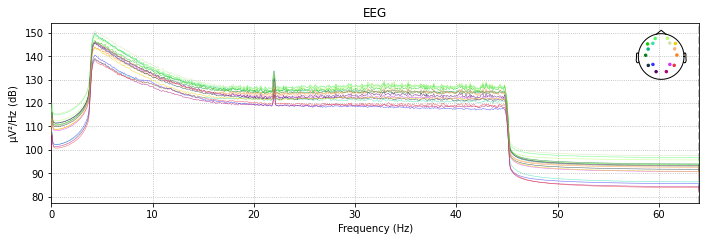

In [11]:
filt_raw.plot_psd()

In [45]:
X = filt_raw.get_data()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

X = X.reshape(400,16,-1)
X = X[:,:,384:]
X.shape

(400, 16, 7680)

In [46]:
eeg_emo_5s = np.empty((X.shape[0]*12,X.shape[1],640))
targets_5s = np.empty((X.shape[0]*12,4))

for i,k in enumerate(range(0,eeg_emo_5s.shape[0],12)):
    for j in range(12):
        eeg_emo_5s[k+j,:,:] = X[i,:,640*j:640*(j+1)]
        targets_5s[k+j,:] = targets[i,:]
print(eeg_emo_5s.shape)
print(targets_5s.shape)

(4800, 16, 640)
(4800, 4)


In [47]:
# valence 0-low ,1 high 
valence = []
mean_valence = np.mean(targets_5s[:,0])
for i in range(targets_5s.shape[0]):
    if targets_5s[i,0] < mean_valence :
        valence.append(0)
    else :
        valence.append(1)
valence = np.array(valence)
valence.shape

(4800,)

In [48]:
from tensorflow.keras.utils import to_categorical
valence = to_categorical(valence)
valence.shape

(4800, 2)

In [49]:
train_size = 0.7
val_size = 0.1
idx = np.arange(0,eeg_emo_5s.shape[0],1)
ts = int(train_size*eeg_emo_5s.shape[0]) 
vs = int(val_size*eeg_emo_5s.shape[0]) 
idx_train = idx[0:ts]
idx_val = idx[ts:ts+vs]
idx_test = idx[ts+vs:]

In [50]:
x_train = eeg_emo_5s[idx_train]
x_val = eeg_emo_5s[idx_val]
x_test = eeg_emo_5s[idx_test]

y_train = valence[idx_train]
y_val = valence[idx_val]
y_test = valence[idx_test]
print('x_train',x_train.shape)
print('x_val',x_val.shape)
print('x_test',x_test.shape)

print('y_train',y_train.shape)
print('y_val',y_val.shape)
print('y_test',y_test.shape)

x_train (3360, 16, 640)
x_val (480, 16, 640)
x_test (960, 16, 640)
y_train (3360, 2)
y_val (480, 2)
y_test (960, 2)


In [51]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [52]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

batch_size = 20
def dataload(X, y):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y)
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    return dataset_tensor
    #return DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)

train_loader = DataLoader(dataload(x_train, y_train), batch_size=batch_size, shuffle=True)

valid_loader = DataLoader(dataload(x_val, y_val), batch_size=batch_size, shuffle=False)

test_loader = DataLoader(dataload(x_test, y_test), batch_size=batch_size, shuffle=False)

In [53]:
#model hyperparameters
hidden_dim1 = 64
hidden_dim2= 32 
embed_dim = x_train.shape[2]
#ed2 = hidden_dim*2
output_dim = y_train.shape[1]
num_layers = 1
bidirectional = True
dropout = 0.5

#training hyperparameters
num_epochs =200
lr=0.0001

In [54]:
import torch.nn as nn
from torch.nn import functional as F

class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
               
        self.layer1 = nn.Sequential(
            nn.Conv1d(16, 32, 4, stride=2),
            nn.ReLU(),
            nn.Dropout(p=0.1))      
        self.lstm = nn.LSTM(319, hidden_dim1, num_layers=num_layers,
                    bidirectional=bidirectional, 
                    dropout=dropout,
                    batch_first=True)
        self.fc = nn.Linear(hidden_dim1*2, output_dim)   
    
    
    def attention_net(self, lstm_output, final_state):
        hidden = final_state.unsqueeze(2)  # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, seq_len, 1]
        soft_attn_weights = F.softmax(attn_weights, 1)
        # [batch_size, n_hidden * num_directions(=2), seq_len] * [batch_size, seq_len, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights.cpu().data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]
    
    def forward(self, x):
        out0 = self.layer1(x)
        out,(hn, cn) = self.lstm(out0)
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        
        attn_output, attention = self.attention_net(out, hn)
        
        return self.fc(attn_output)

In [55]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.Conv2d, nn.Conv2d)):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.kaiming_normal_(param) #<---here

In [56]:
model = LSTM().cuda(3)
model.apply(initialize_weights)

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM(
  (layer1): Sequential(
    (0): Conv1d(16, 32, kernel_size=(4,), stride=(2,))
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (lstm): LSTM(319, 64, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [57]:
# Loss and optimizer
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-5)

In [58]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc/2

In [59]:
def train(model, loader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    for i, (features, label) in enumerate(loader): 
        features   = features.cuda(3)
        label = label.cuda(3)
        #predict
        predictions = model(features)
        #calculate loss
        loss = criterion(predictions, label)
        """l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = loss + l2_lambda * l2_norm""" 
        acc = binary_accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [60]:
def evaluate(model, loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (features, label) in enumerate(loader): 
            features   = features.cuda(3)
            label = label.cuda(3)

            predictions = model(features)
            
            loss = criterion(predictions, label)
            acc = binary_accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
for epoch in range(num_epochs):

    train_loss,train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss,valid_acc = evaluate(model, valid_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),'tensor.pt')
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Train Loss: 0.696 | Train Acc: 50.46%
	 Val. Loss: 0.694 |  Val. Acc: 50.63%
Epoch: 02 | Train Loss: 0.692 | Train Acc: 52.78%
	 Val. Loss: 0.714 |  Val. Acc: 38.23%
Epoch: 03 | Train Loss: 0.690 | Train Acc: 54.30%
	 Val. Loss: 0.708 |  Val. Acc: 37.08%
Epoch: 04 | Train Loss: 0.690 | Train Acc: 53.75%
	 Val. Loss: 0.715 |  Val. Acc: 38.75%
Epoch: 05 | Train Loss: 0.686 | Train Acc: 55.70%
	 Val. Loss: 0.723 |  Val. Acc: 39.48%
Epoch: 06 | Train Loss: 0.683 | Train Acc: 57.01%
	 Val. Loss: 0.704 |  Val. Acc: 48.13%
Epoch: 07 | Train Loss: 0.680 | Train Acc: 57.16%
	 Val. Loss: 0.734 |  Val. Acc: 36.67%
Epoch: 08 | Train Loss: 0.675 | Train Acc: 58.11%
	 Val. Loss: 0.742 |  Val. Acc: 38.23%
Epoch: 09 | Train Loss: 0.667 | Train Acc: 59.57%
	 Val. Loss: 0.725 |  Val. Acc: 45.00%
Epoch: 10 | Train Loss: 0.660 | Train Acc: 60.49%
	 Val. Loss: 0.759 |  Val. Acc: 39.69%
Epoch: 11 | Train Loss: 0.649 | Train Acc: 60.97%
	 Val. Loss: 0.765 |  Val. Acc: 39.58%
Epoch: 12 | Train Los

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

In [ ]:
model.load_state_dict(torch.load('tensor.pt'))
test_loss , test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')